In [6]:
#Importamos las librerias necesarias
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from multiprocessing import Manager
from sklearn.preprocessing import MinMaxScaler
from bacteria_Mejorada import bacteria_mejorada
from fastaReader import fastaReader

In [7]:
# Parámetros ajustables
numeroDeBacterias = 4
iteraciones = 3
dAttr = 0.1
wAttr = 0.002
dRepel = 0.1
wRepel = 0.001
corridas = 30

In [8]:
# Leer archivo FASTA
reader = fastaReader()
secuencias = [list(seq) for seq in reader.seqs]
numSec = len(secuencias)

In [11]:
def ejecutar_bfoa_mejorado():
    manager = Manager()
    poblacion = manager.list(range(numeroDeBacterias))
    for i in range(numeroDeBacterias):
        bacterium = []
        for j in range(numSec):
            bacterium.append(secuencias[j])
        poblacion[i] = list(bacterium)

    operadorBacterial = bacteria_mejorada(numeroDeBacterias)
    veryBest = [None, None, None]
    globalNFE = 0

    start_time = time.time()

    for it in range(iteraciones):
        operadorBacterial.tumbo_inteligente(numSec, poblacion, numGaps=200)  # 👈 Corrección aquí
        operadorBacterial.cuadra(numSec, poblacion)
        operadorBacterial.creaGranListaPares(poblacion)
        operadorBacterial.evaluaBlosum()
        operadorBacterial.creaTablasAtractRepel(poblacion, dAttr, wAttr, dRepel, wRepel)
        operadorBacterial.creaTablaInteraction()
        operadorBacterial.creaTablaFitness()
        globalNFE += operadorBacterial.getNFE()
        bestIdx, bestFitness = operadorBacterial.obtieneBest(globalNFE)
        if (veryBest[0] is None) or (bestFitness > veryBest[1]):
            veryBest[0] = bestIdx
            veryBest[1] = bestFitness
            veryBest[2] = deepcopy(poblacion[bestIdx])
        operadorBacterial.replaceWorst(poblacion, veryBest[0])
        operadorBacterial.resetListas(numeroDeBacterias)

    end_time = time.time()
    tiempo = end_time - start_time
    return {
        "fitness": veryBest[1],
        "tiempo": tiempo,
        "blosum": operadorBacterial.blosumScore[veryBest[0]],
        "interaccion": operadorBacterial.tablaInteraction[veryBest[0]]
    }


In [12]:
resultados = []
for i in range(corridas):
    print(f"Ejecutando corrida {i+1}/{corridas}...")
    resultado = ejecutar_bfoa_mejorado()
    resultados.append(resultado)

df_mejorado = pd.DataFrame(resultados)

Ejecutando corrida 1/30...
BEST #3: Fitness=6923.510100929749, BLOSUM=10922.0, Interaction=1.5101009297477521, Gaps=200, NFE=38
BEST #3: Fitness=6081.510100929749, BLOSUM=10080.0, Interaction=1.5101009297477521, Gaps=200, NFE=76
BEST #1: Fitness=6406.510100929749, BLOSUM=10405.0, Interaction=1.5101009297477521, Gaps=200, NFE=114
Ejecutando corrida 2/30...
BEST #0: Fitness=7017.510100929749, BLOSUM=11016.0, Interaction=1.5101009297477521, Gaps=200, NFE=38
BEST #1: Fitness=6317.510100929749, BLOSUM=10316.0, Interaction=1.5101009297477521, Gaps=200, NFE=76
BEST #0: Fitness=5902.510100929749, BLOSUM=9901.0, Interaction=1.5101009297477521, Gaps=200, NFE=114
Ejecutando corrida 3/30...
BEST #1: Fitness=6355.510100929749, BLOSUM=10354.0, Interaction=1.5101009297477521, Gaps=200, NFE=38
BEST #3: Fitness=6511.510100929749, BLOSUM=10510.0, Interaction=1.5101009297477521, Gaps=200, NFE=75
BEST #3: Fitness=6281.510100929749, BLOSUM=10280.0, Interaction=1.5101009297477521, Gaps=200, NFE=113
Ejecutan

In [13]:
# Mostrar estadísticas
display(df_mejorado.describe())

,fitness,tiempo,blosum,interaccion
count,30.000000,30.000000,30.000000,30.000000
mean,6869.669448,41.630233,1.766667,1.766667
std,286.024600,7.725655,1.104328,1.104328
min,6209.510101,35.663114,0.000000,0.000000
25%,6672.510101,36.209618,1.000000,1.000000
50%,6884.510101,39.107526,2.000000,2.000000
75%,7037.010101,43.616584,3.000000,3.000000
max,7672.510101,67.121232,3.000000,3.000000


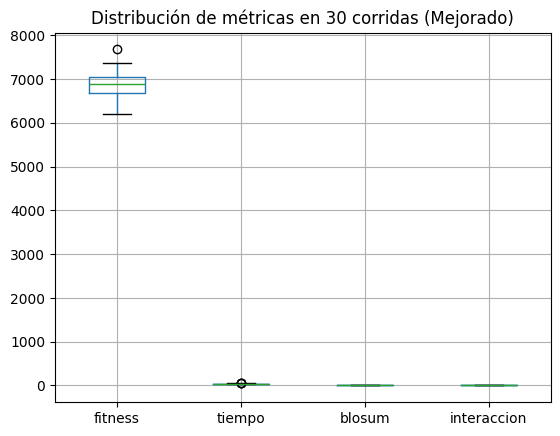

In [14]:
# Boxplot
plt.figure()
df_mejorado.boxplot(column=["fitness", "tiempo", "blosum", "interaccion"])
plt.title("Distribución de métricas en 30 corridas (Mejorado)")
plt.show()

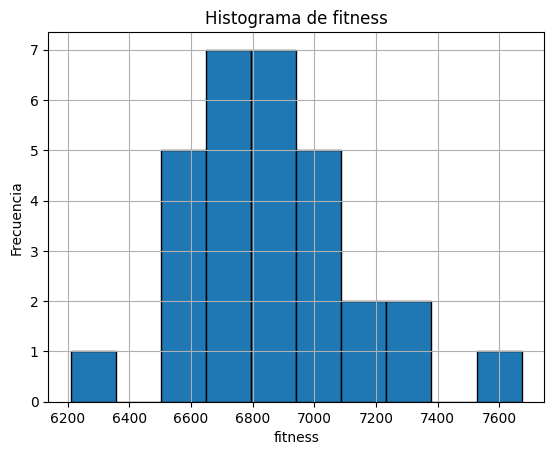

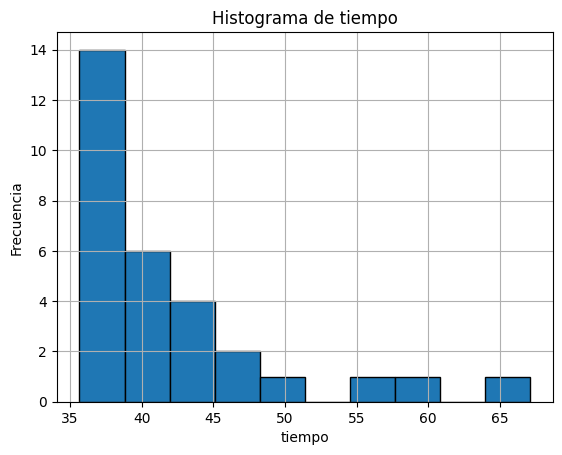

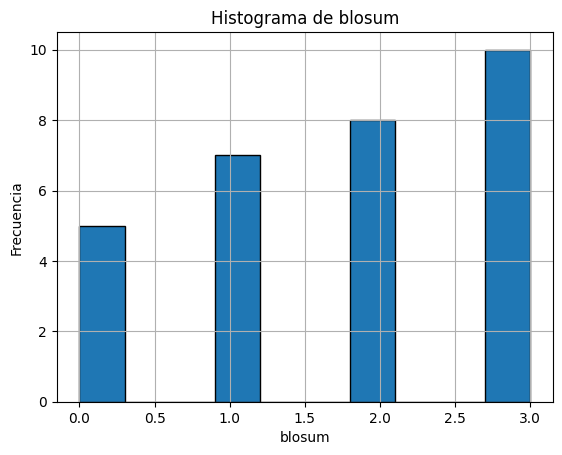

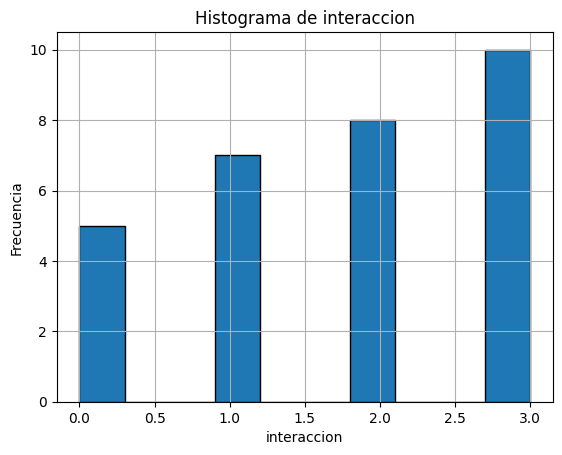

In [15]:
# Histogramas
metrics = ["fitness", "tiempo", "blosum", "interaccion"]
for metric in metrics:
    plt.figure()
    df_mejorado[metric].hist(bins=10, edgecolor='black')
    plt.title(f"Histograma de {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

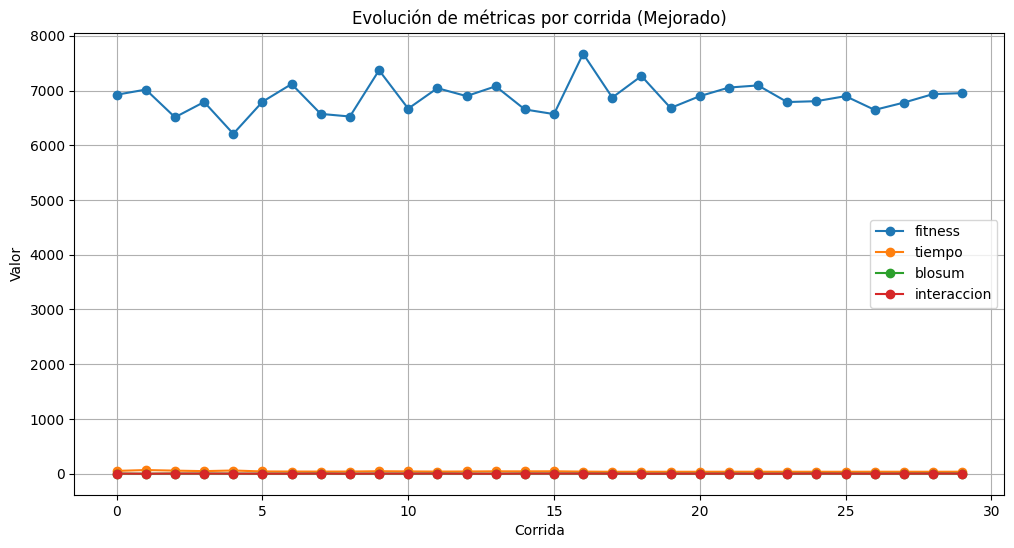

In [16]:
# Evolución corrida por corrida
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df_mejorado[metric], label=metric, marker='o')
plt.title("Evolución de métricas por corrida (Mejorado)")
plt.xlabel("Corrida")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

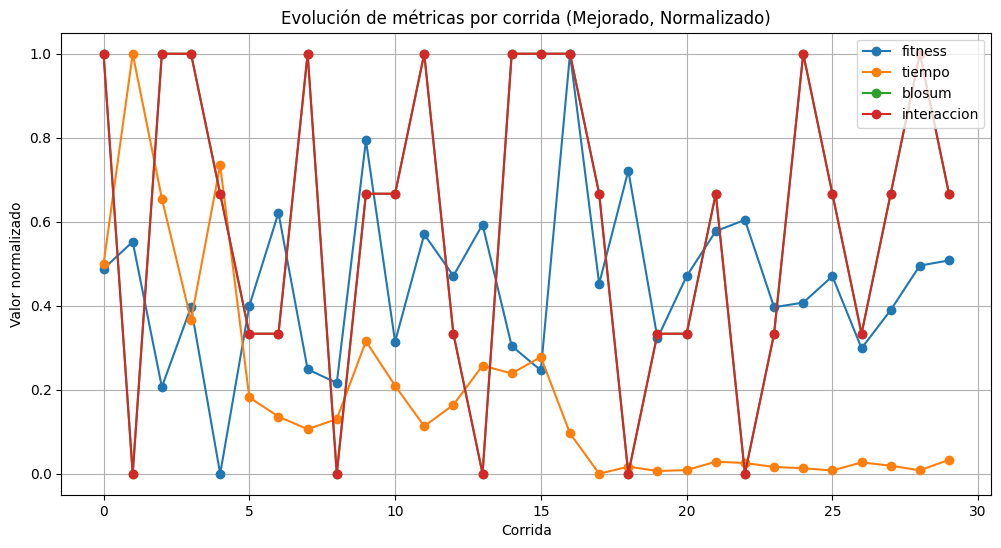

In [17]:
# Evolución normalizada
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_mejorado), columns=df_mejorado.columns)

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df_normalizado[metric], label=metric, marker='o')
plt.title("Evolución de métricas por corrida (Mejorado, Normalizado)")
plt.xlabel("Corrida")
plt.ylabel("Valor normalizado")
plt.legend()
plt.grid(True)
plt.show()


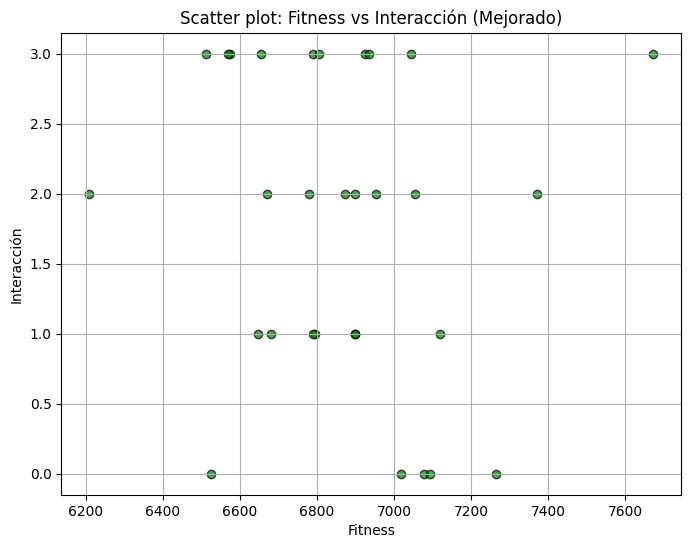

In [18]:
# Scatter plot: Fitness vs Interacción
plt.figure(figsize=(8, 6))
plt.scatter(df_mejorado["fitness"], df_mejorado["interaccion"], c='green', alpha=0.7, edgecolors='black')
plt.title("Scatter plot: Fitness vs Interacción (Mejorado)")
plt.xlabel("Fitness")
plt.ylabel("Interacción")
plt.grid(True)
plt.show()

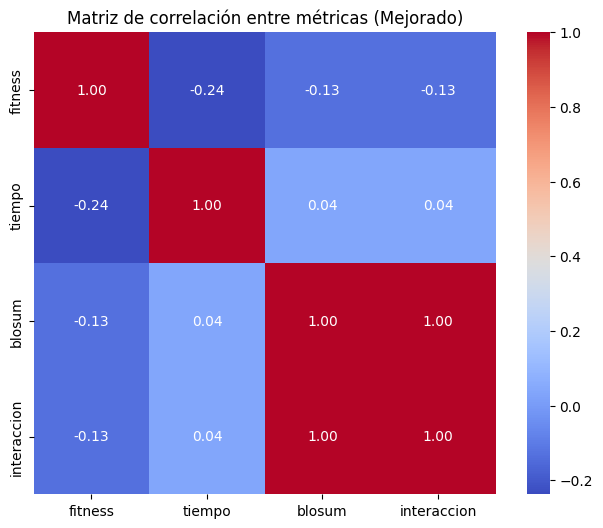

In [19]:
# Matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df_mejorado.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de correlación entre métricas (Mejorado)")
plt.show()

In [20]:
# Guardar resultados
df_mejorado.to_csv("Data/Resultados_BFOA_Mejorado.csv", index=False)